# Comparing the statistics of synthetic scRNA-Seq data generated by BoolODE and scBoolSeq

IN this notebook we showcase how scBoolSeq produces synthetic scRNA-Seq data which better fits the mean ~ variance and mean ~ dropout rate relationships of real datasets.

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import statsmodels.api as sm
from plotnine import *

import scboolseq
from scboolseq import scBoolSeq

In [3]:
%matplotlib inline

In [4]:
%ls data_filtered_vargenes/*csv

data_filtered_vargenes/GSE122466_Retina.csv
data_filtered_vargenes/GSE122466_Retina_vargenes_batch1.csv
data_filtered_vargenes/GSE130973_human_skin.csv
data_filtered_vargenes/GSE156234_Macrophages.csv
data_filtered_vargenes/GSE60361_mouse_brain.csv
data_filtered_vargenes/GSE81682_Hematopoiesis.csv


In [5]:
reference = raw_reference = pd.read_csv("data_filtered_vargenes/GSE122466_Retina_vargenes_batch1.csv", index_col=0)
raw_reference.head()

,Tubb3,Malat1,Stmn2,Fgf15,Gap43,Xist,Sncg,Hmgb2,Top2a,Meg3,...,Prdm13,Kif14,Rpl24,Etfb,Cd320,Fam98b,Odf2,Fbxo36,Rbp4,Pou4f2
Lane1_AAACCTGAGATGTCGG,0.000000,14.687273,9.280150,10.278990,0.000000,0.000000,8.282469,10.863565,8.282469,8.282469,...,0.0,0.0,11.737682,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
Lane1_AAACCTGCAATCCAAC,0.000000,14.568977,0.000000,10.200911,0.000000,0.000000,0.000000,10.200911,0.000000,0.000000,...,0.0,0.0,10.615642,9.616560,0.000000,8.618397,0.000000,0.0,0.0,0.0
Lane1_AAACCTGGTTCCTCCA,12.822128,16.422850,11.681013,0.000000,12.722607,0.000000,12.615708,0.000000,0.000000,11.237565,...,0.0,0.0,9.402599,6.607977,0.000000,6.607977,6.607977,0.0,0.0,0.0
Lane1_AAACCTGTCCAATGGT,12.601411,16.106194,10.514703,0.000000,8.517658,0.000000,8.517658,10.099994,0.000000,0.000000,...,0.0,0.0,10.099994,0.000000,8.517658,0.000000,0.000000,0.0,0.0,0.0
Lane1_AAACGGGAGGCAATTA,0.000000,14.858160,0.000000,12.375060,7.766719,11.082672,6.773328,11.889742,11.461031,7.766719,...,0.0,0.0,11.284220,6.773328,0.000000,8.349471,6.773328,0.0,0.0,0.0


In [6]:
#"boolean_trace.csv"
trace = pd.read_csv("boolode_gsd_trace.csv", index_col=0)
print(trace.shape)
configurations = trace.groupby(trace.index).agg(lambda x: x.mode())
configurations

(700, 19)


,AMH,CBX2,CTNNB1,DHH,DKK1,DMRT1,FGF9,FOXL2,GATA4,NR0B1,NR5A1,PGD2,RSPO1,SOX9,SRY,UGR,WNT4,WT1mKTS,WT1pKTS
Sertoli,1,0,0,1,1,1,1,0,1,0,1,1,0,1,1,0,0,1,1
granulosa,0,0,1,0,0,0,0,1,1,1,0,0,1,0,0,0,1,1,0
start,1,0,1,1,0,1,0,0,1,1,1,1,1,1,0,1,1,1,1
t_Sertoli_1,1,0,0,1,1,1,0,0,1,0,1,1,1,1,0,1,1,1,1
t_Sertoli_2,1,0,0,1,1,1,1,0,1,0,1,1,1,1,1,1,0,1,1
t_granulosa_1,1,0,1,0,0,0,0,0,1,1,1,1,1,0,0,1,1,1,1
t_granulosa_2,1,0,1,0,0,0,0,1,1,1,0,1,1,0,0,1,1,1,0


In [7]:
configurations.loc[configurations.UGR == 0, :].index.unique()

Index(['Sertoli', 'granulosa'], dtype='object')

In [8]:
%time scbool = scBoolSeq().fit(reference)

CPU times: user 1min, sys: 1.14 s, total: 1min 1s
Wall time: 11.8 s


CPU times: user 358 ms, sys: 371 ms, total: 729 ms
Wall time: 1.93 s


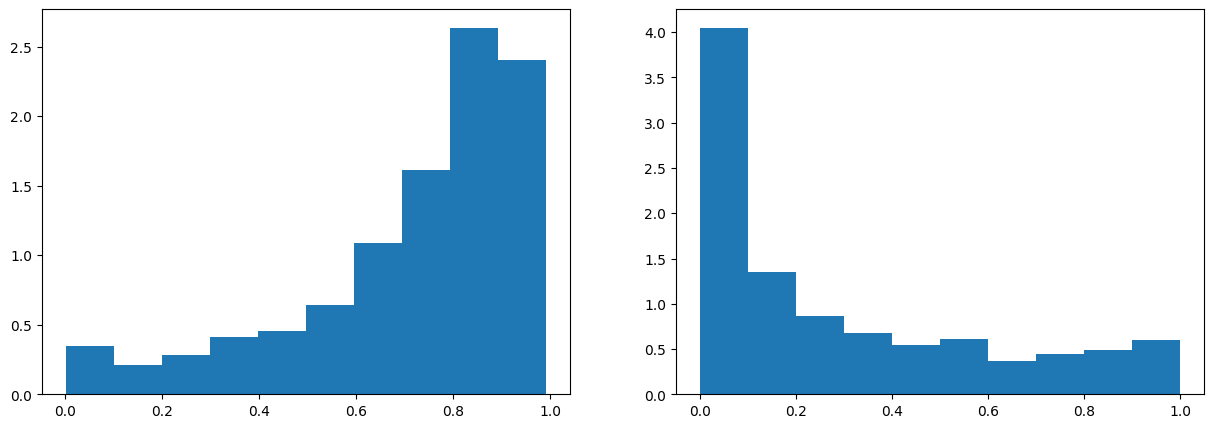

In [9]:
%%time
a, b = .3, .7

SEED = 1234
rng = np.random.default_rng(SEED)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax[0].hist(scbool.criteria_.DropOutRate.values, density=True)
ax[1].hist(rng.beta(a, b, size=1_000), density=True)
new_data =  scbool.synthetic_rna_from_boolean_states(
    trace, 
    n_samples_per_state=10,
)
new_data_beta =  scbool.synthetic_rna_from_boolean_states(
    trace, 
    n_samples_per_state=10, 
    dropout_rates=rng.beta(a, b, size=trace.shape[1])
)
new_data_constant = scbool.synthetic_rna_from_boolean_states(
    trace, 
    n_samples_per_state=10, 
    dropout_rates=np.array([0.5 for _ in range(trace.shape[1])]),
    dropout_mode = "uniform"
)
new_data_no_dor= scbool.synthetic_rna_from_boolean_states(
    trace, 
    n_samples_per_state=10, 
    dropout_mode = None
)

In [10]:
%%time
our_scbool_natural_dor = scBoolSeq().fit(new_data)
our_scbool_beta_dropout = scBoolSeq().fit(new_data_beta)
our_scbool_constant_dropout = scBoolSeq().fit(new_data_constant)
our_scbool_no_dor = scBoolSeq().fit(new_data_no_dor)

CPU times: user 1min 13s, sys: 1min 37s, total: 2min 50s
Wall time: 11.5 s


In [11]:
!ls boolODE_data/

boolode1_dor_30_70.csv  boolode1_dor_90_50.csv  boolode1_no_dor.csv


In [12]:
from pathlib import Path as path
from sklearn.utils import Bunch

In [13]:
%%time
boolode_dataframes = Bunch(**{
    file.name.replace(file.suffix, ''): pd.read_csv(file, index_col=0).T
    for file in path("./boolODE_data/").resolve().glob("boolode*csv")
})
boolode_dataframes.keys()

CPU times: user 79.9 ms, sys: 3.99 ms, total: 83.9 ms
Wall time: 83.6 ms


dict_keys(['boolode1_dor_30_70', 'boolode1_dor_90_50', 'boolode1_no_dor'])

In [14]:
%%time 

boolode_scbool = Bunch(**{
    name: scBoolSeq().fit(8*_data) # The 8 is needed to match the amplitude of mean values in real data
    for name, _data in boolode_dataframes.items()
})

CPU times: user 10.1 s, sys: 786 ms, total: 10.9 s
Wall time: 1.57 s


In [15]:
to_consider = [
    'boolode1_dor_30_70',
    'boolode1_dor_90_50',
    'boolode1_no_dor',
]

boolode1_dor_30_70 0 0
boolode1_dor_90_50 0 1
boolode1_no_dor 0 0


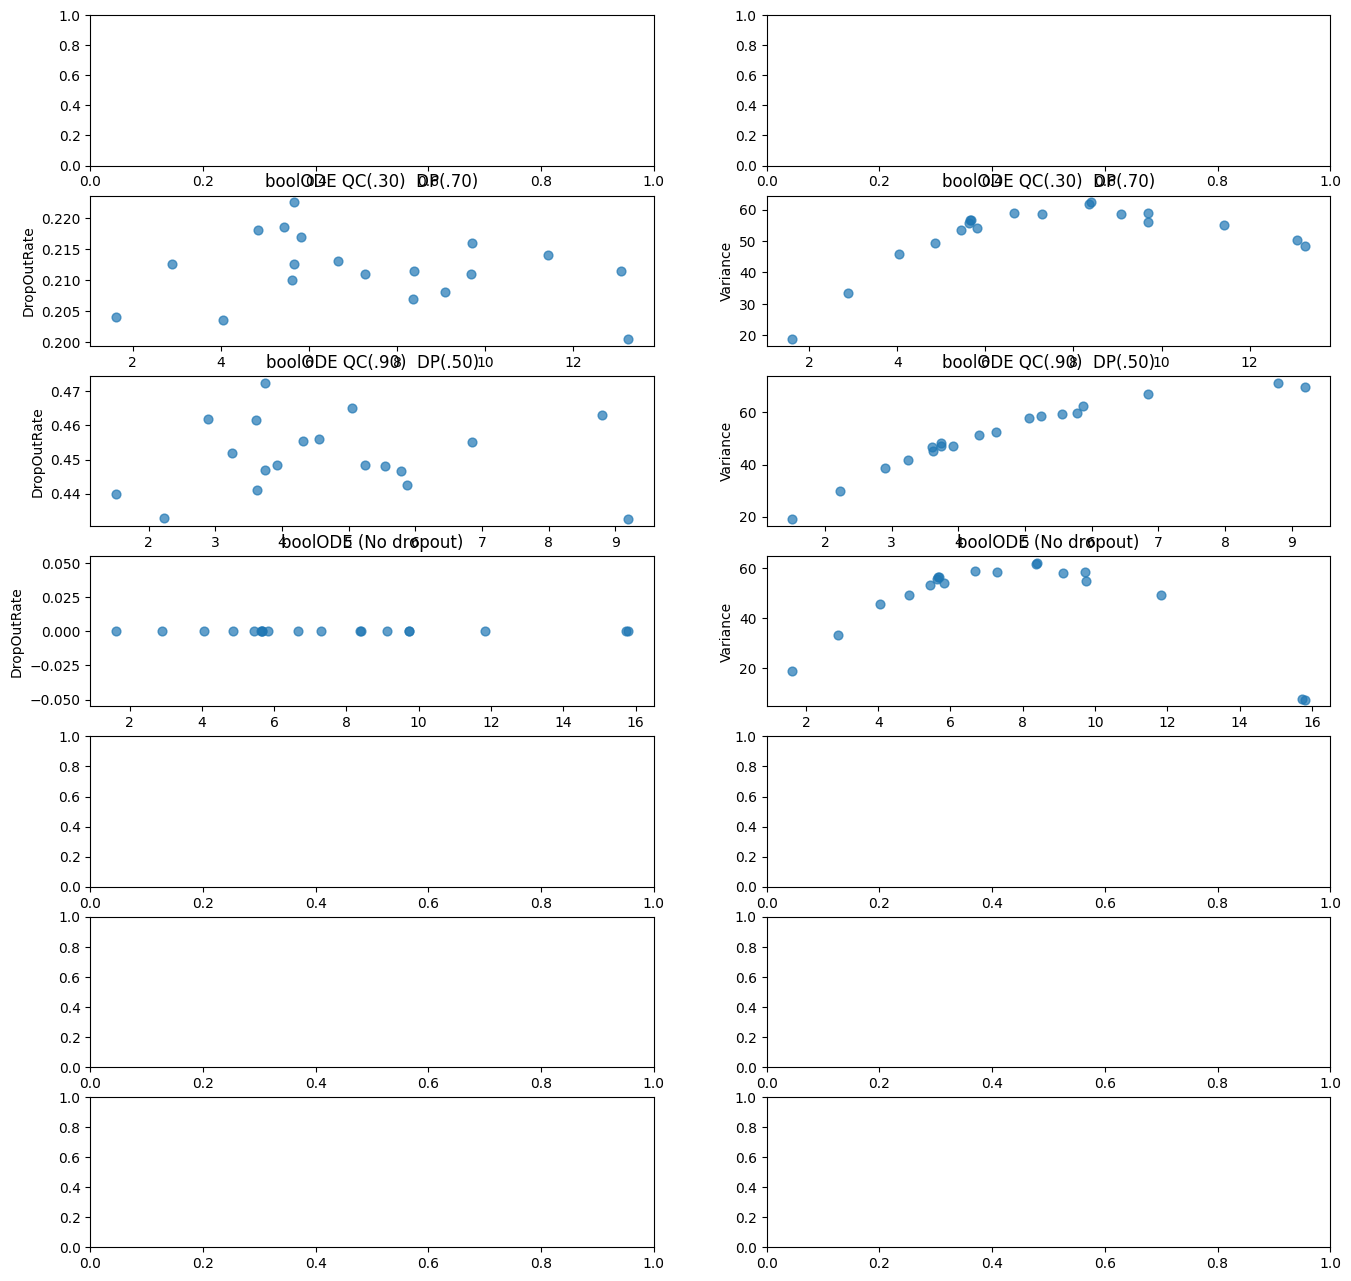

In [16]:
_cols = "Mean|Variance|DropOutRate".split("|")
N = len(to_consider) + 4
fig, axs = plt.subplots(nrows=N, ncols=2, figsize=(16,16))

for i, name in enumerate(to_consider):
    print(name, i//N, i%2)
    _ax, _ax2 = axs[i + 1]
    _crit_ = boolode_scbool[name].criteria_
    _crit_ = _crit_[_crit_.columns[_crit_.columns != 'Category']]
    _x = _crit_.copy(deep=True)
    _x.plot.scatter(x="Mean", y="DropOutRate", alpha=.7, ax=_ax, s=40)
    _x.plot.scatter(x="Mean", y="Variance", alpha=.7, ax=_ax2, s=40)
    
    _title = (
        "(No dropout)"
        if 'no' in name
        else f"QC(.{name.split('_')[-2]})  DP(.{name.split('_')[-1]})"
    )
    _ax.set_title(f"boolODE {_title}")
    _ax2.set_title(f"boolODE {_title}")


In [17]:
_1, _2 = axs[0]
_t = "Reference Dataset"
_1.set_title(_t); _2.set_title(_t);
_x = scbool.criteria_
_x.plot.scatter(x="Mean", y="DropOutRate", alpha=.7, ax=_1, c="red")
_x.plot.scatter(x="Mean", y="Variance", alpha=.7, ax=_2, c="red")

<Axes: title={'center': 'Reference Dataset'}, xlabel='Mean', ylabel='Variance'>

In [18]:
_1, _2 = axs[-3]
_t = "scBoolSeq reference Dropout"
_1.set_title(_t); _2.set_title(_t);
_x = our_scbool_natural_dor.criteria_
_x.plot.scatter(x="Mean", y="DropOutRate", alpha=.7, ax=_1, c="green", s=40)
_x.plot.scatter(x="Mean", y="Variance", alpha=.7, ax=_2, c="green", s=40)

<Axes: title={'center': 'scBoolSeq reference Dropout'}, xlabel='Mean', ylabel='Variance'>

In [19]:
_1, _2 = axs[-2]
_t = f"scBoolSeq constant Dropout = 0.5"
_1.set_title(_t); _2.set_title(_t);
_x = our_scbool_constant_dropout.criteria_
_x.plot.scatter(x="Mean", y="DropOutRate", alpha=.7, ax=_1, c="green", s=40)
_x.plot.scatter(x="Mean", y="Variance", alpha=.7, ax=_2, c="green", s=40)

<Axes: title={'center': 'scBoolSeq constant Dropout = 0.5'}, xlabel='Mean', ylabel='Variance'>

In [20]:
_1, _2 = axs[-1]
_t = f"scBoolSeq DropOutRate = 0.0"
_1.set_title(_t); _2.set_title(_t);
_x = our_scbool_no_dor.criteria_
_x.plot.scatter(x="Mean", y="DropOutRate", alpha=.7, ax=_1, c="green", s=40)
_x.plot.scatter(x="Mean", y="Variance", alpha=.7, ax=_2, c="green", s=40)

<Axes: title={'center': 'scBoolSeq DropOutRate = 0.0'}, xlabel='Mean', ylabel='Variance'>

In [21]:
for i in range(len(axs)-1):
    for j in range(len(axs[0])):
        axs[i][j].tick_params('x', labelbottom=False)
        axs[i][j].get_xaxis().set_visible(False)
    
for i in range(len(axs)):
    axs[i][1].set_ylim(-5, 75)
    if i > 0:
        axs[i][0].sharey(axs[0][0])

In [22]:
fig.tight_layout()

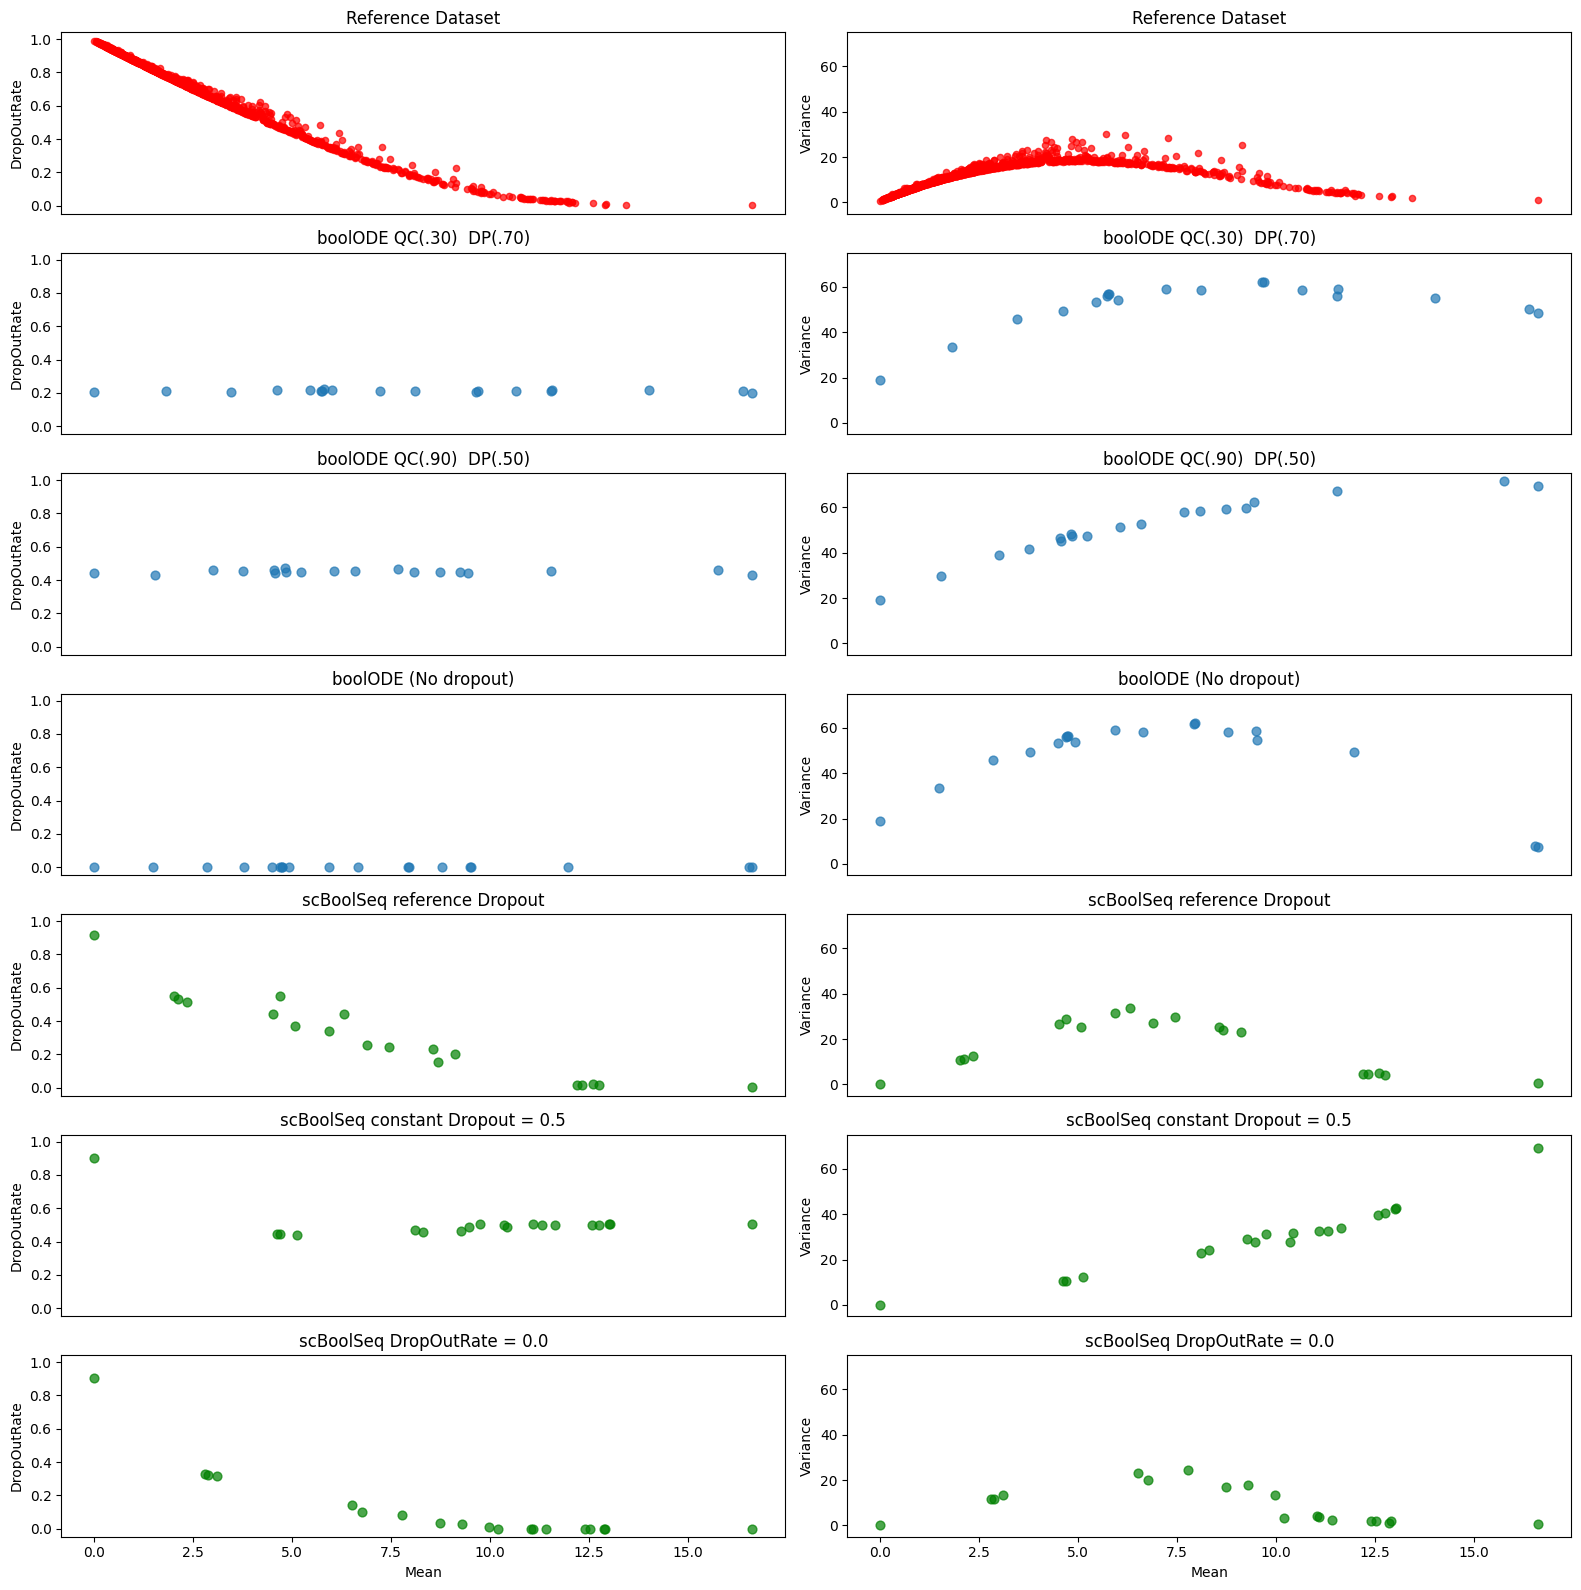

In [23]:
fig

In [24]:
for _format in ['pdf', 'png', 'png', 'svg']:
    fig.savefig(f"comparison.{_format}", format=_format)

In [25]:
_x[["Mean", "DropOutRate", "Variance"]].describe()

,Mean,DropOutRate,Variance
count,19.000000,19.000000,19.000000
mean,8.896532,0.119083,9.162785
std,4.303915,0.224076,8.315054
min,0.005283,0.000000,0.000374
25%,6.655182,0.000000,2.084678
50%,9.987002,0.007143,3.960177
75%,11.911468,0.119000,15.283957
max,16.631674,0.907857,24.299473


In [26]:
fig.tight_layout()

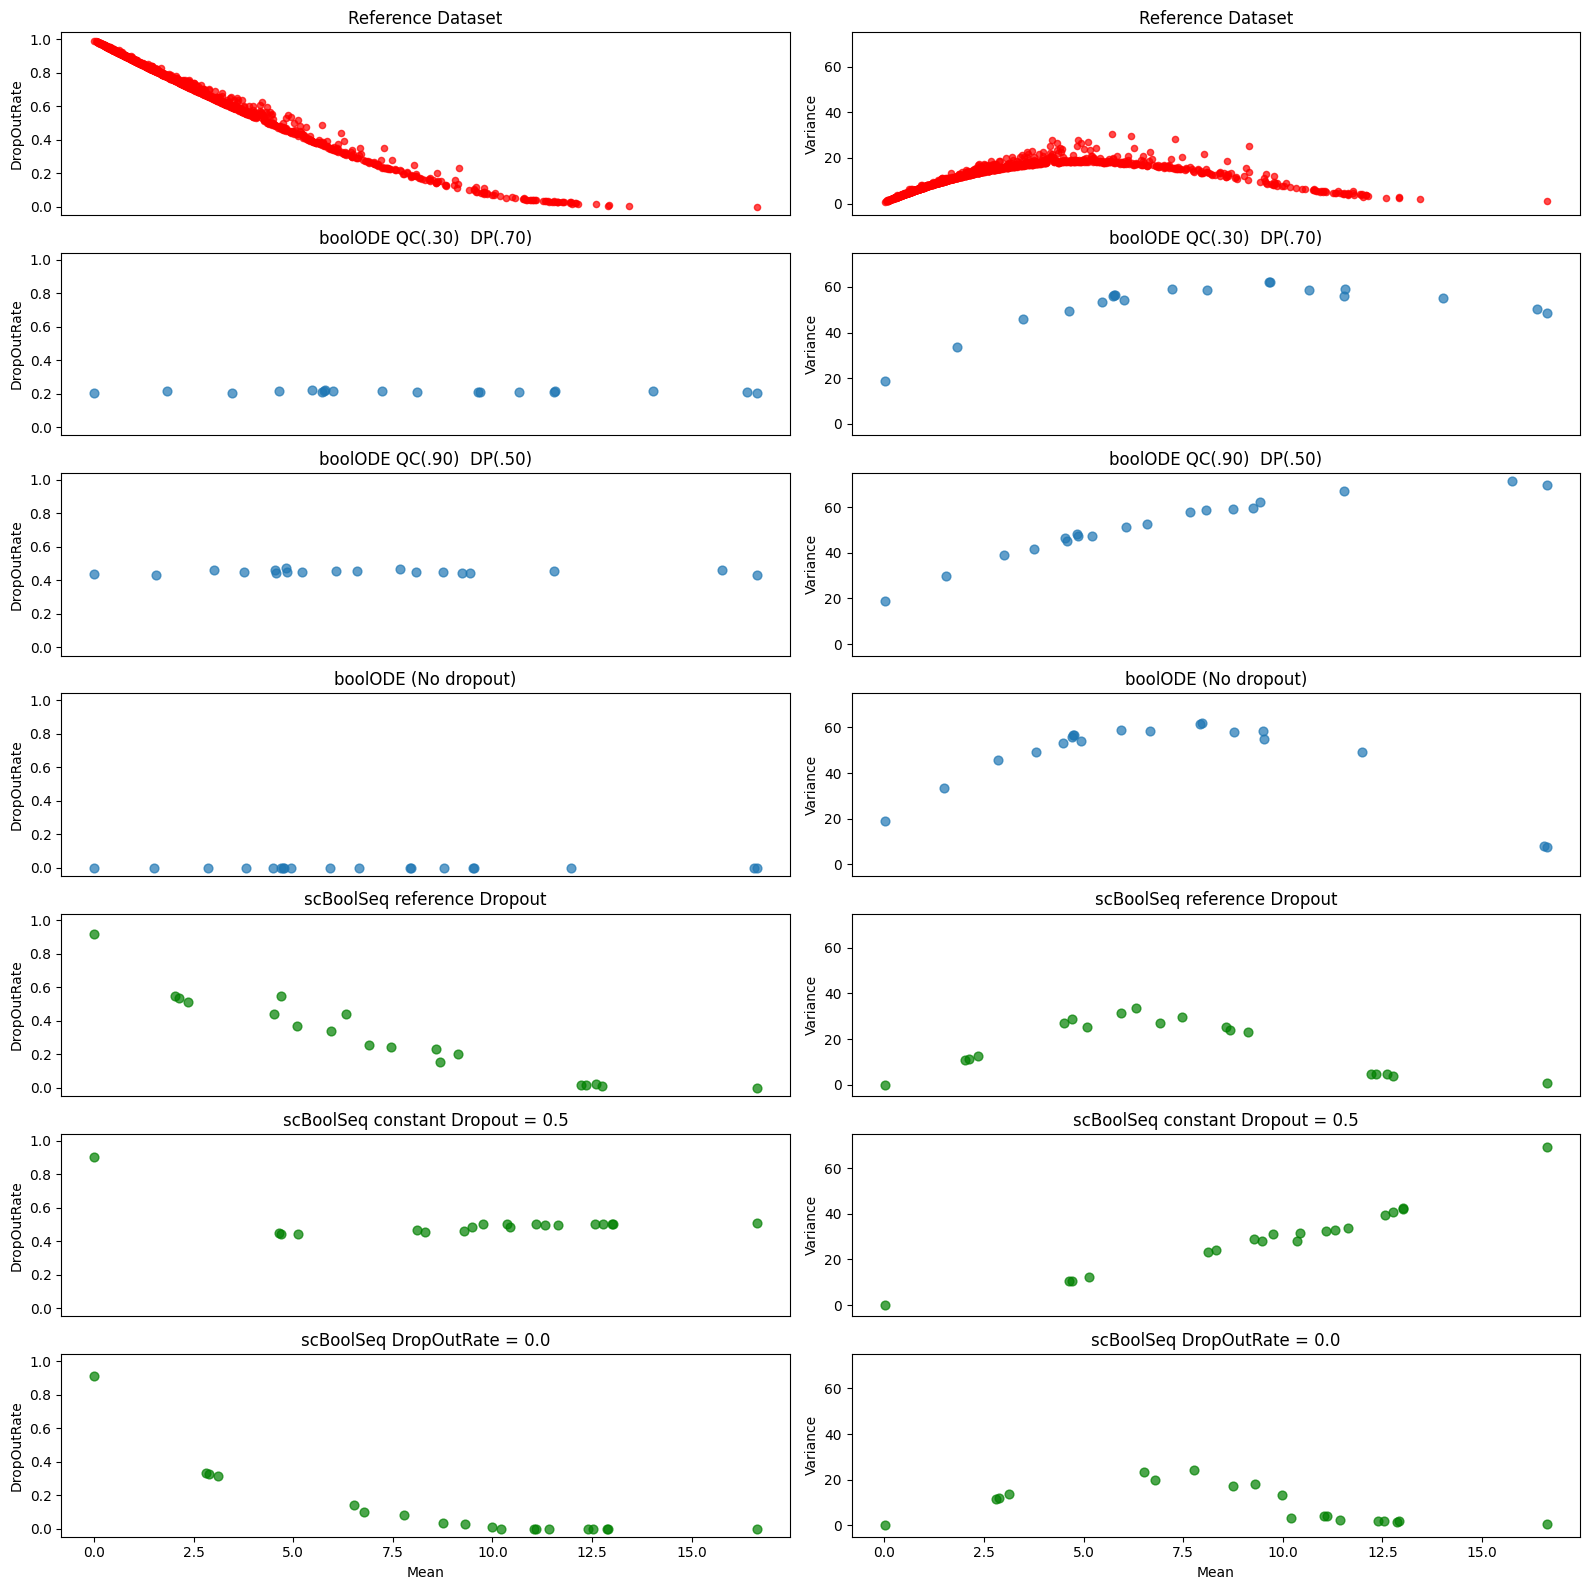

In [27]:
fig